## Post-processing script for 3DLeafSeg

#### Last edited by: M. Jenkins
#### Date:  03/04/2018

In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io
from skimage.transform import rescale
from skimage.morphology import remove_small_objects
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage.filters import maximum_filter, median_filter, minimum_filter, percentile_filter

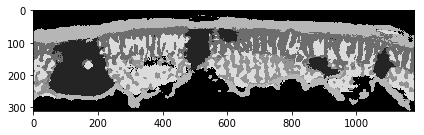

In [2]:
# Import full stack prediction from ML algorithm
filepath = '../../../ML_microCT/results/'
results_folder = 'test2_invert_starch'
img = io.imread(filepath+results_folder+'/fullstack_prediction.tif')
io.imshow(img[20,:,:])
io.show()

In [3]:
# Remove 'dangling' epidermal pixels
epid = (img==182)
epid_rmv_parts = np.array(epid, copy=True)
for i in range(0,epid_rmv_parts.shape[0]):
    epid_rmv_parts[i,:,:] = remove_small_objects(epid[i,:,:], min_size=800)

# Write an array of just the removed particles
epid_parts = epid ^ epid_rmv_parts 

# Replace the small connected epidermal particles (< 800 px^2) with BG value
img[epid_parts==1] = 0

# Free up some memory
del epid_rmv_parts
del epid

In [4]:
# Define 3D array of distances from lower and upper epidermises
a = range(0,img.shape[1])
b = np.tile(a,(img.shape[2],img.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

# Determine the lower edge of the spongy/palisade mesophyll
c = (img==146)
d = (b*c)
m_low = np.argmax(d, axis=1)
        
# Determine the lower edge of the vascular bundle
c = (img==146)
d = (b*c)
v_low = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img==182)
d = (b*c)
e_low = np.argmax(d, axis=1)
e_low = np.maximum(e_low, m_low) # Checks if mesophyll cells are below lower epidermis
                                 # Changes lowest mesophyll pixel to epidermal class
e_low = np.maximum(e_low, v_low) # Similar to above, but with vascular bundle
epi_low = np.zeros(img.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1

# Determine the upper edge of the epidermis
b2 = np.flip(b,1)
d = (b2*c)
e_up = np.argmax(d, axis=1)
epi_up = np.zeros(img.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

In [5]:
# Generate a binary stack with the pixels inside the epidermis set equal to 1
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
        
# Generate a binary stack with the pixels outside the epidermis set equal to 1
epi_out = (epi_in==0)*1

In [6]:
# Set all background identified as BG that lies within epidermal boundaries as IAS
# Set all background identified as IAS that lies outside epidermal boundaries as BG
img2 = np.array(img, copy=True)
img2[(img2==219)*(epi_out==1)] = 0
img2[(img2==0)*(epi_in==1)] = 219

In [7]:
# Define filters for clipping off artefactual IAS protrusions due to dangling epidermis
def dbl_pct_filt(arr):
    out = percentile_filter(
        percentile_filter(
            arr, 
            size=30, 
            percentile=10),
        size=30,percentile=90)
    return(out)

def min_max_filt(arr):
    out = minimum_filter(
        maximum_filter(arr,20),
        20)
    return out

In [8]:
# Define 3D array of distances from lower and upper epidermises
a = range(0,img2.shape[1])
b = np.tile(a,(img2.shape[2],img2.shape[0],1))
b = np.moveaxis(b,[0,1,2],[2,0,1])

# Determine the lower edge of the spongy/palisade mesophyll
c = (img2==146)
d = (b*c)
m_low = np.argmax(d, axis=1)

# Determine the lower edge of the epidermis
c = (img2==182)
d = (b*c)
e_low = np.argmax(d, axis=1)
e_low = np.maximum(e_low, m_low) # Checks if mesophyll cells are below lower epidermis
e_low = np.apply_along_axis(dbl_pct_filt, 0, arr = e_low)
e_low = np.apply_along_axis(min_max_filt, 0, arr = e_low)
e_low = np.apply_along_axis(min_max_filt, 0, arr = e_low)
epi_low = np.zeros(img2.shape)
for z in range(0,epi_low.shape[0]):
    for x in range(0,epi_low.shape[2]):
        epi_low[z,e_low[z,x],x] = 1

# Determine the upper edge of the epidermis
b2 = np.flip(b,1)
d = (b2*c)
e_up = np.argmax(d, axis=1)
epi_up = np.zeros(img2.shape)
for z in range(0,epi_up.shape[0]):
    for x in range(0,epi_up.shape[2]):
        epi_up[z,e_up[z,x],x] = 1

# Combine the lower and upper edge of epidermis into a single numpy array
epi_both = epi_up + epi_low

In [9]:
# Generate a binary stack with the pixels inside the epidermis set equal to 1
epi_in = np.zeros(img.shape, dtype=np.uint16)
for y in range(0,epi_in.shape[2]):
    for z in range(0,epi_in.shape[0]):
        epi_in[z,e_up[z,y]:e_low[z,y],y] = 1
        
# Generate a binary stack with the pixels outside the epidermis set equal to 1
epi_out = (epi_in==0)*1

In [10]:
# Set all background identified as BG that lies within epidermal boundaries as IAS
# Set all background identified as IAS that lies outside epidermal boundaries as BG
img3 = np.array(img2, copy=True)
img3[(img3==219)*(epi_out==1)] = 0
img3[(img3==0)*(epi_in==1)] = 219

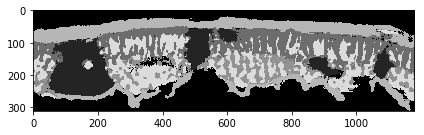

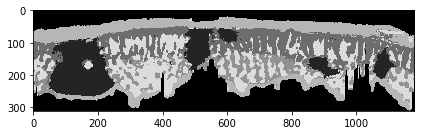

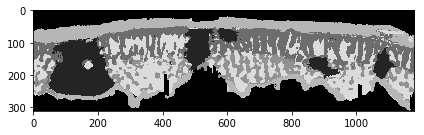

In [11]:
slice = 20
io.imshow(img[slice,:,:])
io.show()
io.imshow(img2[slice,:,:])
io.show()
io.imshow(img3[slice,:,:])
io.show()

In [12]:
# Save post-processed predicted stack
io.imsave(filepath+results_folder+'/prediction_postprocess6.tif', img3)